# Energy Expenditure

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import copy
import seaborn as sns
import pickle

import Tracab as tracab
import Tracking_Visuals as vis
import Tracking_Velocities as vel
import helpers
import scipy.signal as signal
import scipy

import importlib
importlib.reload(tracab)
importlib.reload(helpers)
importlib.reload(vis)

In [2]:
# config
current_dir = os.path.dirname(os.getcwd())
fpath = os.path.join(current_dir, 'TrackingSample') # path to directory of Tracab data
LEAGUE = 'DSL'

## Data

In [3]:
# read frames, match meta data, and data for individual players
fname = '984628'
frames_tb, match_tb, team1_players, team0_players = tracab.read_tracab_match_data(
    LEAGUE, fpath, fname, verbose=True)

Reading match metadata
Reading match tracking data
Timestamping frames
Measuring velocities
home goalkeeper(s):  [1]
away goalkeeper(s):  [73]
0 67615
67616 139808


### Pickle objects

In [21]:
# save
for obj, filename in zip([frames_tb, match_tb, team1_players, team0_players], ['frames', 'match', 'team1', 'team0']):
    with open(os.path.join('./saved', filename),'wb') as outfile:
        pickle.dump(obj, outfile)
    

PicklingError: Can't pickle <class 'Tracab.tracab_frame'>: it's not the same object as Tracab.tracab_frame

In [22]:
# read
for obj, filename in zip([frames_tb, match_tb, team1_players, team0_players], ['frames', 'match', 'team1', 'team0']):
    with open(os.path.join('./saved', filename),'rb') as infile:
        obj = pickle.load(infile)


EOFError: Ran out of input

### Visualize

In [87]:
# pick a player
player = team0_players[5]

In [100]:
# metrics available
target_ex = player.frame_targets[100]
vars(target_ex)

{'team': 1,
 'sys_target_ID': 14,
 'jersey_num': 25,
 'pos_x': -1464.0,
 'pos_y': -992.0,
 'speed': 3.02,
 'timestamp': 4.0,
 'vx': 0.071,
 'vy': 3.286,
 'v_filter': 3.287,
 'ax': 5.293,
 'ay': -0.032,
 'a_filter': 5.293}

# Acceleration

In [35]:
# get values
velocities = helpers.get_all_values(player, 'v_filter')
axs = helpers.get_all_values(player, 'ax', start=10, skip_last=10)
accelerations = helpers.get_all_values(player, 'a_filter', start=10, skip_last=10)

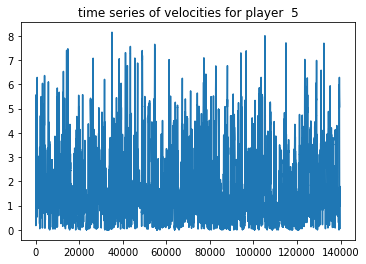

In [36]:
# velocities
plt.plot(velocities)
plt.title('time series of velocities for player  {}'.format(player.jersey_num))
plt.show()

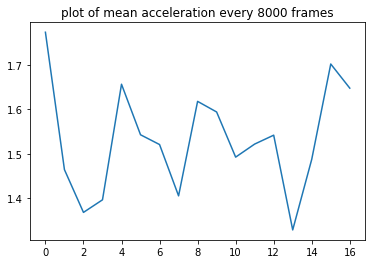

In [37]:
# plot every 
k = 8000
mean_every_k = helpers.get_mean_every_k(accelerations, k=k)
plt.plot(mean_every_k)
plt.title('plot of mean acceleration every {} frames'.format(k))
plt.show()

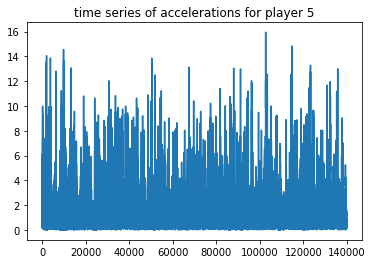

In [38]:
# accelerations
plt.plot(accelerations)
plt.title('time series of accelerations for player {}'.format(player.jersey_num))
plt.show()

# Energy expenditure calculation

We want to make make time series of energy expenditure for each player

1. **VeBVD =** sum of acceleration vectors
2. **metabolic power**  = 5th degree polynomial
3. product 

In [104]:
import Tracking_Fatigue as fatigue
importlib.reload(fatigue)


<module 'Tracking_Fatigue' from '/Users/jeffbalkanski/research_soccer/SoccerTrackingData3/Tracking_Fatigue.py'>

In [185]:
all_players = list(team0_players.items()) + list(team1_players.items())


## VeBDA - Vector Dynamic Body Acceleration,
the VeDBA at time t, is `a_magnitude`. there is no a_magnitude on first frame!

For a possession starting at $s_n$ and ending at $e_n$ , the VeBDA for that posession is 
$$V'_n = \sum_{t=s_n}^{e_n}V_t$$

In [106]:
# compute
fatigue.estimate_player_VeBDA(team1_players, team0_players)

In [120]:
ts = helpers.get_all_values(player, 'timestamp', start=1)

In [ ]:
for team, player in all_players:
    vebda_toplot = helpers.get_all_values(player, 'VeBDA', start=1)
    plt.plot(vebda_toplot)
    plt.title('Plot of VeBDA for player {} of team {}'.format(player.jersey_num, player.teamID))
    plt.savefig('./figures/VeBDA/time_series_all_{}_player_{}.jpg'.format(player.teamID, player.jersey_num))

## Metabolic power
First must find the **energy cost**
$$EC =155.4i^5 −30.4i^4 −43.3i^3 +46.3i^2 +19.5i +3.6$$

In [157]:
def estimate_metabolic_power(team1_players, team0_players):
    # get for all players
    all_players = list(team0_players.items()) + list(team1_players.items())
    for (num, player) in all_players:
        
        # get accelerations
        ax = helpers.get_all_values(player, 'ax', start=1)
        ay = helpers.get_all_values(player, 'ay', start=1)
        vx = helpers.get_all_values(player, 'vx', start=1)
        vy = helpers.get_all_values(player, 'vy', start=1)

        # in m/s^2
        g = 9.81

        # find angle, of equivalent slope
        ix = np.tan(np.pi/2. - np.arctan(g/ax))
        iy = np.tan(np.pi/2. - np.arctan(g/ay)) 

#         # find energy cost
#         EC_x = 155.4*ix**5 - 30.4*ix**4 - 43.3*ix**3 + 46.3*ix**2 + 19.5*ix + 3.6
#         EC_y = 155.4*iy**5 - 30.4*iy**4 - 43.3*iy**3 + 46.3*iy**2 + 19.5*iy + 3.6

#         # equivalent mass ratio
#         mx = np.sqrt((np.power(ax, 2)/g**2) + 1)
#         my = np.sqrt((np.power(ay, 2)/g**2) + 1)

#         # matabolic power
#         Px = np.multiply(EC_x, mx, vx)
#         Py = np.multiply(EC_y, my, vy)

#         metabolic_power = Px + Py

#         # store
#         for i, frame in enumerate(player.frame_targets[1:]):
#             frame.metabolic = metabolic_power[i]

        break



In [158]:
# compute for all players
estimate_metabolic_power(team1_players, team0_players)

/Users/jeffbalkanski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/Users/jeffbalkanski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in arctan
  app.launch_new_instance()
/Users/jeffbalkanski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/jeffbalkanski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in arctan


In [179]:
ax = helpers.get_all_values(player, 'ax', start=1)
ay = helpers.get_all_values(player, 'ay', start=1)

# problem
print('there are many null values of accelerations')
print(np.where(ax == 0)[0].shape, np.where(ay == 0)[0].shape)

there are many null values of accelerations
(31302,) (31253,)


In [149]:
metabolic_lst = helpers.get_all_values(player, 'metabolic', start=1)

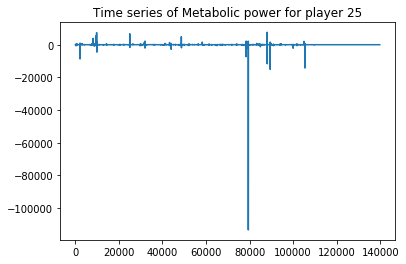

In [152]:
# plot 
plt.plot(metabolic_lst)
plt.title('Time series of Metabolic power for player {}'.format(player.jersey_num))
plt.show()

# relating to physical performance

In [120]:
player = team0_players[11]

# get accelerations
accelerations = helpers.get_all_values(player, 'a_magnitude')

In [126]:
means = helpers.get_mean_every_k(accelerations, 4000)

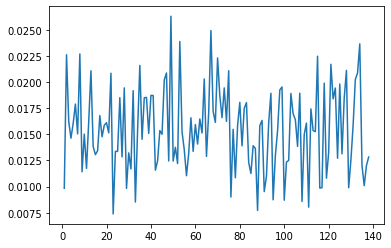

In [125]:
plt.plot(means)

In [127]:
player = team0_players[11]

# get accelerations
accelerations = helpers.get_all_values(player, 'VeBDA')

AttributeError: 'tracab_target' object has no attribute 'VeBDA'

In [ ]:
means = helpers.get_mean_every_k(accelerations, 4000)
plt.plot(means)